In [36]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [37]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

## XGBoost for LSTM imputed dataset


In [4]:
y_true = pd.read_csv(r'output\/CompleteCovid.csv',index_col=0).Asia_confirmed_cases
y_true_train = y_true.loc['2020-01-22 09:00:00':'2020-02-26 02:00:00']
y_true_test =  y_true.loc['2020-02-26 02:30:00':]

X_train = read_csv('output/\lstm/\CompleteCovidTrainLSTM10_0.csv')
X_test = read_csv('output/\lstm/\CompleteCovidTestLSTM10_0.csv')

y_train = X_train.Asia_confirmed_cases
y_test = X_test.Asia_confirmed_cases

X_train = X_train.drop('Asia_confirmed_cases', axis=1)
X_test = X_test.drop('Asia_confirmed_cases', axis=1)


xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                  eval_metric = 'rmse',
                                  max_depth=3,
                                  n_estimators=120,
                                  learning_rate=0.2
                              )
model = xgb_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("\nRMSE: ", np.round(RMSE, 2))


y_true_test_reduced = pd.concat([y_true_test, y_test], axis=1).dropna().iloc[:, 0]
y_pred_reduced = pd.concat([y_true_test, pd.DataFrame(data=y_pred, index=y_true_test.index)], axis=1).dropna().iloc[:, 1]

MSE_real = mse(y_true_test_reduced, y_pred_reduced)
RMSE_real = np.sqrt(MSE_real)

print("\nRMSE with only real values: ", np.round(RMSE_real, 2))


RMSE:  145.12

RMSE with only real values:  13761.07


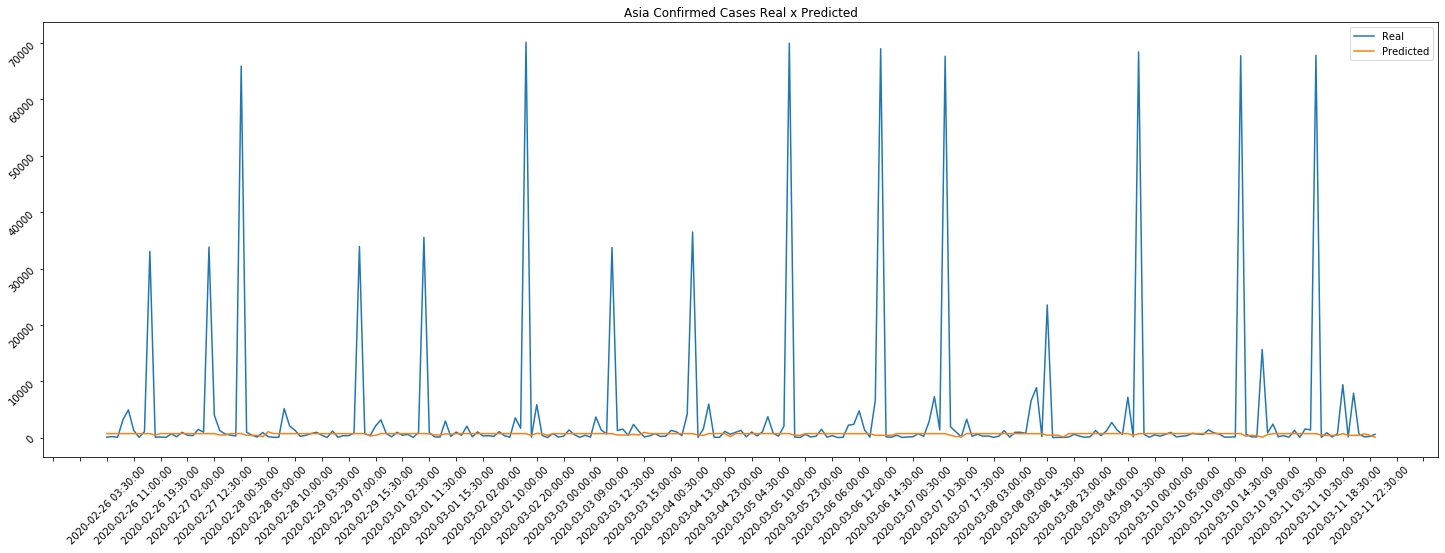

In [35]:
fig,axes=plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(25)
axes.tick_params(labelrotation=45)
axes.xaxis.set_major_locator(plt.MaxNLocator(60)) 
axes.plot(y_true_test_reduced.index, y_true_test_reduced.values, label='Real')
axes.plot(y_pred_reduced.index, y_pred_reduced.values, label='Predicted')
axes.set_title("Asia Confirmed Cases Real x Predicted")
axes.legend()
plt.show()

In [4]:
def run_experiment_multiple_times(n=30):
    result_dict = {}
    result_dict= {'rmse':0, 'true_rmse':0, 'best_model':None, 'best_rmse':999999999999, 'best_true_rmse':999999999999}
    list_rmse = []
    list_true_rmse = []
    
    for i in range(0,n):
        y_true = pd.read_csv(r'output\/CompleteCovid.csv',index_col=0).Asia_confirmed_cases
        y_true_train = y_true.loc['2020-01-22 09:00:00':'2020-02-26 02:00:00']
        y_true_test =  y_true.loc['2020-02-26 02:30:00':]

        X_train = read_csv('output/\lstm/\CompleteCovidTrainLSTM10_'+str(i)+'.csv')
        X_test = read_csv('output/\lstm/\CompleteCovidTestLSTM10_'+str(i)+'.csv')

        y_train = X_train.Asia_confirmed_cases
        y_test = X_test.Asia_confirmed_cases

        X_train = X_train.drop('Asia_confirmed_cases', axis=1)
        X_test = X_test.drop('Asia_confirmed_cases', axis=1)


        xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                          eval_metric = 'rmse',
                                          max_depth=3,
                                          n_estimators=120,
                                          learning_rate=0.2
                                      )
        model = xgb_model.fit(X_train, y_train)


        y_pred = model.predict(X_test)

        MSE = mse(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        
        y_true_test_reduced = pd.concat([y_true_test, y_test], axis=1).dropna().iloc[:, 0]
        y_pred_reduced = pd.concat([y_true_test, pd.DataFrame(data=y_pred, index=y_true_test.index)], axis=1).dropna().iloc[:, 1]

        MSE_real = mse(y_true_test_reduced, y_pred_reduced)
        RMSE_real = np.sqrt(MSE_real)

        print('Round', i, "rmse", RMSE)
        print('Round', i, "true rmse", RMSE_real)
        result_dict['rmse'] += RMSE
        result_dict['true_rmse'] += RMSE_real
        list_rmse.append(RMSE)
        list_true_rmse.append(RMSE_real)
        if result_dict['best_rmse'] > RMSE:
            result_dict['best_rmse'] = RMSE
            result_dict['best_model'] = model
            result_dict['best_true_rmse'] = RMSE_real
    print("STD RMSE", np.std(list_rmse, axis=0))
    print("STD True RMSE", np.std(list_true_rmse, axis=0))
    result_dict['rmse'] = result_dict['rmse']/n
    result_dict['true_rmse'] = result_dict['true_rmse']/n
    return result_dict     

In [5]:
result_dict = run_experiment_multiple_times(n=30)

Round 0 rmse 145.1150478154896
Round 0 true rmse 13761.06648674596
Round 1 rmse 872.393587594378
Round 1 true rmse 13830.000259458753
Round 2 rmse 1006.1020001036724
Round 2 true rmse 13738.069677496049
Round 3 rmse 196.60543728158186
Round 3 true rmse 13752.34565306203
Round 4 rmse 608.2575743941794
Round 4 true rmse 13745.741415385084
Round 5 rmse 427.91107108986165
Round 5 true rmse 13754.2140578529
Round 6 rmse 1437.982875107631
Round 6 true rmse 13830.408259530628
Round 7 rmse 170.41614710419512
Round 7 true rmse 13818.95421431877
Round 8 rmse 777.3176476012706
Round 8 true rmse 13895.798108563498
Round 9 rmse 919.9148565239695
Round 9 true rmse 13816.705685528888
Round 10 rmse 293.9848801088175
Round 10 true rmse 13680.423664882323
Round 11 rmse 1197.8016150655287
Round 11 true rmse 13830.654423849932
Round 12 rmse 636.6786533385786
Round 12 true rmse 13830.20878538115
Round 13 rmse 106.64076448122971
Round 13 true rmse 13841.619450329317
Round 14 rmse 467.1745929735251
Round 14 

In [6]:
result_dict

{'rmse': 558.3314404402178,
 'true_rmse': 13803.85911257101,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.2, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=120, n_jobs=0,
               num_parallel_tree=1, objective='multi:softprob', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'best_rmse': 106.60229292320615,
 'best_true_rmse': 13836.686963456248}